# AI-Based Trading Strategies
## Transformer-based Trading Strategy

An AI-driven trading framework leveraging a Transformer encoder architecture 
to forecast market dynamics and backtest systematic long/short strategies on SPY.

## Setup & Data Prep
### Import Libraries & Dependencies


In [1]:
# --- Imports ---
import os, random, warnings
from pathlib import Path; from dataclasses import dataclass
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LayerNormalization, Dropout  # ⬅️ CHANGE
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D  # ⬅️ NEW for Transformer
from tensorflow.keras.models import Model
try:
    from tensorflow.keras.optimizers.legacy import Adam
except:
    from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Globals ---
OUTPUT_DIR = Path("../outputs/05_TRANSFORMER"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)  # ⬅️ CHANGE: new folder
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Reproducibility ---
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# --- Params ---
PRED_THRESHOLD = 0.4006
THRESH_BAND   = 0.0866
LONG_THRESHOLD, SHORT_THRESHOLD = PRED_THRESHOLD + THRESH_BAND, PRED_THRESHOLD - THRESH_BAND
SEQ_LEN = 28; H_SPLIT = "2022-01-01"
print(f"Thresholds -> SHORT={SHORT_THRESHOLD:.2f}, LONG={LONG_THRESHOLD:.2f}")


Thresholds -> SHORT=0.31, LONG=0.49


In [2]:
# --- Load Dataset Helper ---
def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["Date"], index_col="Date").sort_index()
    df.columns = [c.lower() for c in df.columns]
    numeric_cols = ["open", "high", "low", "close", "adjusted_close", "volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    return df.ffill()

# --- Load Local Dataset ---
data_path = Path("../data/GSPC_fixed.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}")

df = load_data(data_path)
print(f"Data loaded: {df.index.min().date()} → {df.index.max().date()} | {df.shape[0]} rows")

df.head()

Data loaded: 2014-01-06 → 2025-03-07 | 2810 rows


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2014-01-06,1832.3101,1837.16,1823.7300,1826.77,1826.77,3294850000
2014-01-07,1828.7100,1840.10,1828.7100,1837.88,1837.88,3511750000
2014-01-08,1837.9000,1840.02,1831.4000,1837.49,1837.49,3652140000
2014-01-09,1839.0000,1843.23,1830.3800,1838.13,1838.13,3581150000
2014-01-10,1840.0601,1843.15,1832.4301,1842.37,1842.37,3335710000


## Data Visualization
- Plot **S&P 500 adjusted closing prices** over time.

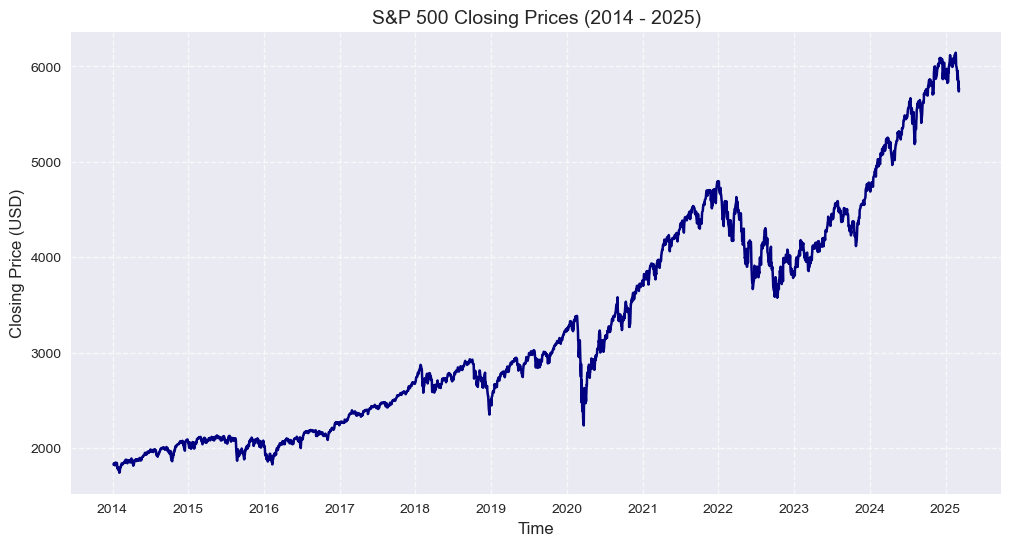

In [3]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("S&P 500 Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()

## Feature Engineering 
### Technical Indicators
LSTM models **learn temporal patterns from sequences**, so we select indicators that enhance **trend detection, volatility awareness, and momentum signals**.  
These features enrich the input data, giving the model information about **trend strength, volatility regimes, and volume confirmation**.

---

| **Category**              | **Indicator**                           | **Best Periods**         | **Why Useful?**                                                                 |
|---------------------------|-----------------------------------------|--------------------------|---------------------------------------------------------------------------------|
| **Return Feature**        | Log Returns                             | 1-day                    | Captures raw daily price dynamics; foundation for return-based modeling         |
| **Volatility Indicator**  | Rolling Std. of Returns                 | Vol(10)                  | Tracks short-term volatility regimes; helps size positions and detect turbulence|
| **Momentum Indicator**    | RSI (Relative Strength Index)           | RSI(14)                  | Detects momentum extremes and overbought/oversold conditions                    |
| **Momentum Indicator**    | MACD (Moving Avg Convergence Divergence)| MACD(12,26,9)            | Highlights momentum shifts and potential trend reversals                        |
| **Volume Indicator**      | OBV (On-Balance Volume)                 | Default (cumulative)     | Confirms price moves with volume flow                                           |
| **Lagged Features**       | Lagged Log Returns                      | lag_1 … lag_7 (7 lags)   | Provide temporal context and allow LSTM to capture autocorrelation structures   |

---

In [4]:
# ===========================================
# Feature Engineering (medium set, skew/kurt kept)
# ===========================================

# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

def ensure_log_returns(df):
    if "log_returns" not in df:
        df["log_returns"] = np.log(df["adjusted_close"]).diff().fillna(0.0)
    return df

def ema(s, span):
    return s.ewm(span=span, adjust=False).mean()

def add_technical_features(df, lags=7):
    df = df.copy()
    px = df["adjusted_close"]

    # Volatility (10d, unannualized)
    df["volatility_10"] = (
        df["log_returns"].rolling(10).std()
        .fillna(df["log_returns"].expanding().std())
    )

    # RSI(14)
    delta = px.diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/14, adjust=False).mean()
    roll_down = down.ewm(alpha=1/14, adjust=False).mean()
    rs = (roll_up / (roll_down.replace(0, np.nan))).fillna(0)
    df["RSI_14"] = (100 - (100 / (1 + rs))).fillna(50)

    # MACD (12,26,9)
    ema12, ema26 = ema(px, 12), ema(px, 26)
    macd_line = ema12 - ema26
    macd_signal = ema(macd_line, 9)
    df["MACD"] = (macd_line - macd_signal).fillna(0)
    df["MACD_line"] = macd_line.fillna(0)
    df["MACD_signal"] = macd_signal.fillna(0)

    # OBV
    if "volume" in df:
        direction = np.sign(px.diff().fillna(0))
        df["OBV"] = (direction * df["volume"]).fillna(0).cumsum()
    else:
        df["OBV"] = 0.0

    # Lagged log returns
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["log_returns"].shift(lag)

    # Multi-horizon returns
    df["ret_3d"]  = np.log(px / px.shift(3))
    df["ret_5d"]  = np.log(px / px.shift(5))
    df["ret_10d"] = np.log(px / px.shift(10))

    # Annualized vol
    df["vol_10d"] = df["log_returns"].rolling(10).std() * np.sqrt(252)
    df["vol_21d"] = df["log_returns"].rolling(21).std() * np.sqrt(252)
    df["vol_63d"] = df["log_returns"].rolling(63).std() * np.sqrt(252)

    # ATR(14)
    if {"high", "low"}.issubset(df.columns):
        high_low   = df["high"] - df["low"]
        high_close = (df["high"] - px.shift()).abs()
        low_close  = (df["low"]  - px.shift()).abs()
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        df["ATR_14"] = tr.rolling(14).mean()
    else:
        df["ATR_14"] = np.nan

    # Skew/Kurtosis over 21d
    df["ret_skew_21"] = df["log_returns"].rolling(21).skew()
    df["ret_kurt_21"] = df["log_returns"].rolling(21).kurt()

    # Volume zscore
    if "volume" in df:
        vol = df["volume"]
        df["vol_zscore_20"] = (vol - vol.rolling(20).mean()) / (vol.rolling(20).std() + 1e-12)
    else:
        df["vol_zscore_20"] = 0.0

    # Vol ratio
    df["vol_ratio"] = df["vol_10d"] / (df["vol_63d"] + 1e-12)

    return df

# --- Build / clean df ---
df = ensure_log_returns(df)
df = add_technical_features(df, lags=7)

# Final feature set
FEATURE_COLS = [
    "log_returns", "volatility_10", "RSI_14", "MACD", "OBV",
    "MACD_line", "MACD_signal",
    "ret_3d", "ret_5d", "ret_10d",
    "vol_10d", "vol_21d", "vol_63d", "vol_ratio",
    "ATR_14",
    "ret_skew_21", "ret_kurt_21",
    "vol_zscore_20",
] + [f"lag_{i}" for i in range(1, 8)]

# Target
if "label" not in df:
    df["label"] = (df["log_returns"].shift(-1) > 0).astype(int)

df = df.dropna(subset=FEATURE_COLS + ["label"]).copy()


## Sequence builder

In [5]:
def create_sequences(X2d, y1d, seq_length=SEQ_LEN):
    """
    Build rolling sequences of length `seq_length`.
    Returns X_seq, y_seq.
    """
    Xv = X2d.values if hasattr(X2d, "values") else np.asarray(X2d)
    yv = y1d.values if hasattr(y1d, "values") else np.asarray(y1d)
    assert len(Xv) == len(yv)
    if len(Xv) < seq_length:
        raise ValueError("Not enough rows for sequence length.")

    # X windows: [i … i+seq_len-1]
    X_seq = np.stack([Xv[i:i+seq_length] for i in range(len(Xv) - seq_length + 1)], axis=0)

    # y aligned with last timestep of each window (index i+seq_len-1)
    y_seq = np.array([yv[i+seq_length-1] for i in range(len(Xv) - seq_length + 1)])

    return X_seq, y_seq

# Model Implementation & Training
## Model Definition & Initialization
### Transformer

In [6]:
# ====================================================
# Transformer Encoder Model for Binary Classification
# ====================================================
def get_transformer_model(input_shape,
                          embed_dim=32, num_heads=4, ff_dim=64,
                          dropout=0.3, lr=0.000162):
    """Builds a simple Transformer encoder for binary classification."""
    inputs = Input(shape=input_shape, name="inputs")

    # --- Linear projection of features (acts as embedding) ---
    x = Dense(embed_dim, name="proj")(inputs)

    # --- Multi-Head Attention ---
    attn_output = MultiHeadAttention(num_heads=num_heads,
                                     key_dim=embed_dim,
                                     name="mha")(x, x)
    x = LayerNormalization(name="ln_attn")(x + attn_output)   # residual + norm

    # --- Feed-Forward Network (FFN) ---
    ffn = Dense(ff_dim, activation="relu", name="ffn_1")(x)
    ffn = Dense(embed_dim, name="ffn_2")(ffn)
    x = LayerNormalization(name="ln_ffn")(x + ffn)            # residual + norm

    # --- Global pooling across timesteps ---
    x = GlobalAveragePooling1D(name="gap")(x)
    x = Dropout(dropout, name="dropout")(x)

    # --- Output layer ---
    outputs = Dense(1, activation="sigmoid", name="output")(x)

    # --- Build & compile ---
    model = Model(inputs, outputs, name="transformer_encoder")
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [7]:
# --- Build Transformer model ---
model = get_transformer_model((SEQ_LEN, len(FEATURE_COLS)))
model.summary()

Model: "transformer_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 25)]             0         []                            
                                                                                                  
 proj (Dense)                (None, 28, 32)               832       ['inputs[0][0]']              
                                                                                                  
 mha (MultiHeadAttention)    (None, 28, 32)               16800     ['proj[0][0]',                
                                                                     'proj[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOp  (None, 28, 32)               0         ['proj[0][0]

## Cross-Validation Diagnostics (Stages A–G)

In [8]:
# ===========================================
# Cross-Validation Diagnostics (Stages A–G)
# ===========================================
tscv = TimeSeriesSplit(n_splits=6, test_size=252)

X_base = df[FEATURE_COLS]
y_all  = df["label"]

preds_cv, labels_cv, idx_cv = [], [], []
fold_rows = []
last_scaler = None

for k, (tr_pos, va_pos) in enumerate(tscv.split(X_base)):
    tr_idx = X_base.index[tr_pos]; va_idx = X_base.index[va_pos]
    
    # --- Features (train/val, no leakage) [removed regime features]
    Xtr_2d = df.loc[tr_idx, FEATURE_COLS].values
    Xva_2d = df.loc[va_idx, FEATURE_COLS].values


    # --- Scaling
    sc = StandardScaler().fit(Xtr_2d)
    Xtr = sc.transform(Xtr_2d); Xva = sc.transform(Xva_2d)

    # --- Targets
    ytr = y_all.loc[tr_idx]; yva = y_all.loc[va_idx]

    # --- Sequence construction
    Xtr_seq, ytr_seq = create_sequences(Xtr, ytr, SEQ_LEN)
    Xva_seq, yva_seq = create_sequences(Xva, yva, SEQ_LEN)
    va_seq_idx = va_idx[SEQ_LEN-1:]

    # --- Model init + training
    model = get_transformer_model((SEQ_LEN, Xtr_seq.shape[2]))
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=0)

    model.fit(
        Xtr_seq, ytr_seq,
        validation_data=(Xva_seq, yva_seq),
        epochs=20, batch_size=64,
        verbose=0,
        callbacks=[es, rl]
    )

    # --- Predictions
    pv = model.predict(Xva_seq, verbose=0).flatten()
    preds_cv.extend(pv)
    labels_cv.extend(yva_seq)
    idx_cv.extend(va_seq_idx)

    # --- Metrics
    yhat = (pv >= PRED_THRESHOLD).astype(int)
    fold_rows.append({
        "fold": k+1,
        "accuracy":  accuracy_score(yva_seq, yhat),
        "precision": precision_score(yva_seq, yhat, zero_division=0),
        "recall":    recall_score(yva_seq, yhat, zero_division=0),
        "f1":        f1_score(yva_seq, yhat, zero_division=0),
        "roc_auc":   roc_auc_score(yva_seq, pv),
        "pr_auc":    average_precision_score(yva_seq, pv),
    })
    last_scaler = sc

# --- Collect CV results
preds_cv = np.array(preds_cv)
labels_cv = np.array(labels_cv)
idx_cv = pd.DatetimeIndex(idx_cv)

df_folds = pd.DataFrame(fold_rows)
display(df_folds)
print("Mean (fold):")
display(df_folds.mean(numeric_only=True))

# --- Persist diagnostics for Stage A/F sweeps 
np.save(OUTPUT_DIR/"cv_predictions.npy", preds_cv)
np.save(OUTPUT_DIR/"cv_labels.npy", labels_cv)
np.save(OUTPUT_DIR/"cv_index.npy", idx_cv.values.astype("datetime64[ns]"))

,fold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,1,0.568889,0.568889,1.0,0.725212,0.492912,0.579359
1,2,0.586667,0.586667,1.0,0.739496,0.474096,0.589877
2,3,0.537778,0.537778,1.0,0.699422,0.496980,0.520424
3,4,0.444444,0.444444,1.0,0.615385,0.497520,0.452021
4,5,0.560000,0.560000,1.0,0.717949,0.425926,0.523457
5,6,0.573333,0.573333,1.0,0.728814,0.484173,0.575564


Mean (fold):


fold         3.500000
accuracy     0.545185
precision    0.545185
recall       1.000000
f1           0.704380
roc_auc      0.478601
pr_auc       0.540117
dtype: float64

### Backtesting Module

In [9]:
# ====================================================
# Backtesting Module (Config + Engine) 
# ====================================================
from dataclasses import dataclass

@dataclass
class BTConfig:
    # Thresholds
    long_threshold: float = 0.55
    short_threshold: float = 0.45
    neutral_band: bool = True   # do nothing in (short, long)

    # Position management
    min_hold_days: int = 1
    stop_daily: float = -0.02
    # stop_trailing: float = -0.08
    roll_loss_window: int = 10
    roll_loss_thresh: float = -0.05

    # Vol targeting
    use_vol_targeting: bool = True
    vol_window: int = 15
    target_annual_vol: float = 0.12
    max_leverage: float = 2.0
    vol_floor: float = 1e-8

    # Costs
    cost_bps_per_turnover: float = 5.0  # 5 bps per turnover event


def run_backtest_clean(
    df: pd.DataFrame,
    predictions: pd.Series | np.ndarray,
    pred_index: pd.DatetimeIndex,
    cfg: BTConfig = None,
    price_col: str = "adjusted_close",
    ret_col: str = "log_returns",
):
    """
    Leakage-safe backtest:
      - Align strictly to pred_index window
      - Signals from predictions (neutral band optional)
      - Enforce min_hold_days
      - Apply stops (daily, trailing, rolling loss)
      - Simple vol targeting
      - Transaction costs on position changes
      - Turnover & hit_rate computed
    """
    assert ret_col in df.columns, f"{ret_col} missing from df"

    cfg = cfg or BTConfig()

    # ---- Align strictly on pred_index ----
    win_mask = df.index.isin(pred_index)
    out = df.loc[win_mask, [ret_col, price_col]].copy()
    preds = pd.Series(predictions, index=pred_index).loc[out.index]
    out["p"] = preds

    # ---- Raw signal from thresholds ----
    if cfg.neutral_band:
        sig = np.select(
            [out["p"] >= cfg.long_threshold, out["p"] <= cfg.short_threshold],
            [1, -1],
            default=0
        )
    else:
        sig = np.where(out["p"] >= cfg.long_threshold, 1, -1)

    # ---- Enforce min_hold_days + stops ----
    pos = np.zeros(len(sig), dtype=float)
    hold = 0
    rolling_pnl = []

    for i in range(1, len(sig)):
        pos[i] = pos[i-1]
        hold = hold + 1 if pos[i] != 0 else 0
        pnl = pos[i-1] * out[ret_col].iloc[i]

        if pos[i-1] != 0:
            rolling_pnl.append(pnl)
            if len(rolling_pnl) > cfg.roll_loss_window:
                rolling_pnl.pop(0)

            # --- Daily stop ---
            if pnl <= cfg.stop_daily:
                pos[i] = 0; hold = 0; rolling_pnl.clear()
            # --- Rolling loss stop ---
            elif sum(rolling_pnl) <= cfg.roll_loss_thresh:
                pos[i] = 0; hold = 0; rolling_pnl.clear()

        # --- Entry / hold enforcement ---
        if pos[i-1] == 0:
            pos[i] = sig[i]
            hold = 1 if pos[i] != 0 else 0
            rolling_pnl.clear()
        elif hold < cfg.min_hold_days:
            pos[i] = pos[i-1]
        elif sig[i] != pos[i-1]:
            pos[i] = sig[i]
            hold = 1 if pos[i] != 0 else 0
            rolling_pnl.clear()

    out["pos_raw"] = pos

    # ---- Vol targeting ----
    if cfg.use_vol_targeting:
        roll_vol = out[ret_col].rolling(cfg.vol_window).std().clip(lower=cfg.vol_floor)
        target_daily = cfg.target_annual_vol / np.sqrt(252.0)
        lever = (target_daily / roll_vol).clip(upper=cfg.max_leverage)
        out["pos"] = out["pos_raw"] * lever.fillna(0.0)
    else:
        out["pos"] = out["pos_raw"]

    # ---- Costs ----
    pos_change = out["pos"].diff().fillna(0.0)
    turnover_events = (pos_change != 0).astype(int)
    cost = (cfg.cost_bps_per_turnover / 1e4) * np.abs(pos_change)
    out["cost"] = cost

    # ---- Strategy & BH returns ----
    out["strat_log_ret_gross"] = out["pos"].shift(1).fillna(0.0) * out[ret_col]
    out["strat_log_cost"] = np.log1p(-out["cost"].clip(upper=0.999999)).fillna(0.0)
    out["strat_log_ret"] = out["strat_log_ret_gross"] + out["strat_log_cost"]
    out["bh_log_ret"] = out[ret_col]

    # ---- Equity curves ----
    out["strategy_equity"] = np.exp(out["strat_log_ret"].cumsum())
    out["bh_equity"] = np.exp(out["bh_log_ret"].cumsum())

    # ---- Metrics ----
    def ann_mu(x): return x.mean() * 252
    def ann_vol(x): return x.std(ddof=0) * np.sqrt(252)
    def sharpe(x):  return ann_mu(x) / (ann_vol(x) + 1e-12)
    def max_dd(e):  return (e / e.cummax() - 1).min()

    strat_log = out["strat_log_ret"].dropna()
    bh_log    = out["bh_log_ret"].dropna()

    summary = {
        "window_start": str(out.index[0].date()),
        "window_end":   str(out.index[-1].date()),
        "bars":         int(len(out)),
        "total_return": float(np.exp(strat_log.sum()) - 1),
        "bh_total_return": float(np.exp(bh_log.sum()) - 1),
        "cagr":        float(np.exp(ann_mu(strat_log)) - 1),
        "bh_cagr":     float(np.exp(ann_mu(bh_log)) - 1),
        "ann_vol":     float(ann_vol(strat_log)),
        "bh_ann_vol":  float(ann_vol(bh_log)),
        "sharpe":      float(sharpe(strat_log)),
        "bh_sharpe":   float(sharpe(bh_log)),
        "max_drawdown":    float(max_dd(out["strategy_equity"])),
        "bh_max_drawdown": float(max_dd(out["bh_equity"])),
        "hit_rate":    float((strat_log > 0).mean()),
        "turnover":    int(turnover_events.sum()),
    }
    return out, summary

### Stage A – Threshold sweep (diagnostic only)
Stage A sweeps a band of prediction thresholds to understand how Sharpe and related metrics respond without changing the global deployment setting.

,threshold,sharpe,cagr,hit_rate
0,0.351,0.592283,0.084964,0.538519
1,0.361,0.592283,0.084964,0.538519
2,0.371,0.592283,0.084964,0.538519
3,0.381,0.592283,0.084964,0.538519
4,0.391,0.592283,0.084964,0.538519
5,0.401,0.586702,0.084087,0.537778
6,0.411,0.553011,0.079005,0.531852
7,0.421,0.540849,0.077160,0.528148
8,0.431,0.522847,0.073917,0.520741
9,0.451,0.468688,0.064049,0.485926


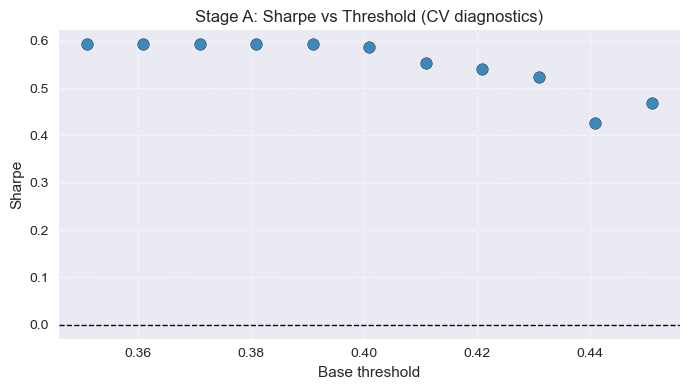

In [10]:
# ====================================================
# Stage A: Sharpe vs Threshold (CV diagnostics)
# ====================================================

try:
    BTConfig
    run_backtest_clean
except NameError:
    raise RuntimeError("Backtest engine (BTConfig/run_backtest_clean) not found in this notebook.")

# --- Align CV predictions and index ---
if len(preds_cv) != len(idx_cv):
    print(f"⚠️ Mismatch detected: preds={len(preds_cv)}, idx={len(idx_cv)}")
    n = min(len(preds_cv), len(idx_cv))
    preds_cv = preds_cv[:n]
    idx_cv   = idx_cv[:n]

pred_series_cv = pd.Series(preds_cv, index=idx_cv, name="p")

# --- Threshold sweep (adaptive around PRED_THRESHOLD) ---
th_grid = np.round(
    np.arange(PRED_THRESHOLD - 0.05, PRED_THRESHOLD + 0.051, 0.01),
    3
)
# Keep thresholds in [0,1]
th_grid = th_grid[(th_grid > 0) & (th_grid < 1)]

rows = []
for th in th_grid:
    cfg = BTConfig(
        long_threshold=min(th + 0.05, 0.99),
        short_threshold=max(th - 0.05, 0.01)
    )
    _, stats = run_backtest_clean(df, pred_series_cv, pred_index=idx_cv, cfg=cfg)
    rows.append({
        "threshold": th,
        "sharpe": stats["sharpe"],
        "cagr": stats["cagr"],
        "hit_rate": stats["hit_rate"]
    })

df_sweep = pd.DataFrame(rows).sort_values("sharpe", ascending=False).reset_index(drop=True)
display(df_sweep)

# --- Plot diagnostics (scatter only) ---
plt.figure(figsize=(7, 4))
plt.scatter(df_sweep["threshold"], df_sweep["sharpe"],
            s=70, color="tab:blue", edgecolor="k", alpha=0.85)
plt.axhline(0, color="k", ls="--", lw=1)
plt.title("Stage A: Sharpe vs Threshold (CV diagnostics)")
plt.xlabel("Base threshold")
plt.ylabel("Sharpe")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Save results ---
df_sweep.to_csv(OUTPUT_DIR/"threshold_sweep_cv.csv", index=False)


## Stage B – Confirmatory Backtests
Stage B reruns the backtest at fixed thresholds to validate the Stage A sweep and capture full diagnostics for each configuration.

In [11]:
# ============================================
# Stage B – Confirmatory Backtests (CV-based)
# ============================================
import contextlib, io

TUNING_DIR = OUTPUT_DIR / 'tuning'
stage_b_root = TUNING_DIR / 'stageB'
stage_b_root.mkdir(parents=True, exist_ok=True)

# Stage B thresholds: center around PRED_THRESHOLD with ±0.02 margin
stage_b_thresholds = [
    round(PRED_THRESHOLD, 3),
    round(PRED_THRESHOLD + 0.01, 3),
    round(PRED_THRESHOLD - 0.01, 3),
]
# Filter to keep thresholds in (0,1)
stage_b_thresholds = [th for th in stage_b_thresholds if 0 < th < 1]

stage_b_records = []


def _save_stage_b_returns_plot(df_bt, out_dir):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df_bt.index, df_bt['log_returns'], label='Actual Returns', alpha=0.45)
    ax.plot(df_bt.index, df_bt['strat_log_ret'], label='Strategy Log Returns', alpha=0.45)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_title('Actual Returns vs Strategy Log Returns')
    ax.set_ylabel('Daily Log Returns')
    ax.legend()
    fig.tight_layout()
    fig.savefig(out_dir / 'returns_comparison.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

def _save_stage_b_equity_plot(df_bt, out_dir):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_bt.index, df_bt['strategy_equity'], label='Strategy Equity Curve', color='blue')
    ax.plot(df_bt.index, df_bt['bh_equity'], label='Buy & Hold Benchmark', color='gray', linestyle='--')
    pred_start = df_bt['p'].first_valid_index()
    if pred_start is not None:
        ax.axvline(pred_start, color='black', linestyle=':', linewidth=0.8, label='Prediction Start')
    ax.set_title('Equity Curve Comparison')
    ax.set_ylabel('Cumulative Value (Rebased)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    fig.tight_layout()
    fig.savefig(out_dir / 'equity_curve_strategy.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

def _save_stage_b_relative_plot(df_bt, out_dir):
    rel = df_bt['strategy_equity'] / df_bt['bh_equity']
    pred_start = df_bt['p'].first_valid_index()
    if pred_start is not None:
        base_value = rel.loc[pred_start]
        if np.isfinite(base_value) and base_value != 0:
            rel = rel / base_value
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_bt.index, rel, label='Strategy vs Benchmark (rebased)', color='green', alpha=0.85)
    ax.axhline(y=1.0, color='black', linestyle=':', linewidth=0.8)
    ax.set_title('Relative Performance vs Benchmark')
    ax.set_ylabel('Relative Ratio (Rebased to 1.0)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    fig.savefig(out_dir / 'relative_performance.png', dpi=200, bbox_inches='tight')
    plt.close(fig)

# --- Run confirmatory tests ---
for base_th in stage_b_thresholds:
    long_th = round(base_th + 0.05, 4)
    short_th = round(base_th - 0.05, 4)
    cfg = BTConfig(long_threshold=long_th, short_threshold=short_th)

    stage_dir = stage_b_root / f'th_{base_th:.2f}'
    stage_dir.mkdir(parents=True, exist_ok=True)

    with contextlib.redirect_stdout(io.StringIO()):
        df_bt, bt_summary = run_backtest_clean(
            df=df,
            predictions=pd.Series(preds_cv, index=idx_cv, name="p"),
            pred_index=idx_cv,
            cfg=cfg,
        )

    _save_stage_b_returns_plot(df_bt, stage_dir)
    _save_stage_b_equity_plot(df_bt, stage_dir)
    _save_stage_b_relative_plot(df_bt, stage_dir)

    stage_b_records.append({
        'threshold': float(base_th),
        'long_threshold': float(long_th),
        'short_threshold': float(short_th),
        'sharpe': float(bt_summary.get('sharpe', np.nan)),
        'cagr': float(bt_summary.get('cagr', np.nan)),
        'max_drawdown': float(bt_summary.get('max_drawdown', np.nan)),
        'turnover': float(bt_summary.get('turnover', np.nan)),
        'hit_rate': float(bt_summary.get('hit_rate', np.nan)),
    })

stage_b_df = pd.DataFrame(stage_b_records)
stage_b_csv = TUNING_DIR / 'stageB_results.csv'
stage_b_df.to_csv(stage_b_csv, index=False)

comparison_cols = ['threshold', 'sharpe', 'cagr', 'max_drawdown', 'turnover', 'hit_rate']
formatters = {
    'threshold': lambda x: f"{x:.2f}",
    'sharpe': lambda x: f"{x:.3f}",
    'cagr': lambda x: f"{x:.3f}",
    'max_drawdown': lambda x: f"{x:.3f}",
    'turnover': lambda x: f"{x:.2f}",
    'hit_rate': lambda x: f"{x:.3f}",
}

stage_b_df

,threshold,long_threshold,short_threshold,sharpe,cagr,max_drawdown,turnover,hit_rate
0,0.401,0.451,0.351,0.586702,0.084087,-0.177173,1309.0,0.537778
1,0.411,0.461,0.361,0.553011,0.079005,-0.183134,1304.0,0.531852
2,0.391,0.441,0.341,0.592283,0.084964,-0.177173,1309.0,0.538519


### Stage C – Risk / BTConfig grid (fast sweep)

In [12]:
# ============================================
# Stage C – Risk / BTConfig grid (fast sweep, CV)
# ============================================
from itertools import product
import contextlib, io

TUNE_DIR   = OUTPUT_DIR / "tuning"
STAGEC_DIR = TUNE_DIR / "stageC_risk"
STAGEC_DIR.mkdir(parents=True, exist_ok=True)

# Use CV predictions directly
predictions = pd.Series(preds_cv, index=idx_cv, name="p")
pred_index  = idx_cv

# --- Dynamic Stage B winner ---
try:
    stage_b_df = pd.read_csv(TUNING_DIR / "stageB_results.csv")
    BASE_TH = float(stage_b_df.sort_values("sharpe", ascending=False).iloc[0]["threshold"])
    print(f"Stage C using Stage B winner: BASE_TH={BASE_TH:.2f}")
except Exception:
    BASE_TH = PRED_THRESHOLD
    print(f"⚠️ Stage B results not found. Using PRED_THRESHOLD={BASE_TH:.2f}")

# --- Base thresholds from Stage B ---
base_kwargs = dict(
    long_threshold = round(BASE_TH + 0.05, 4),
    short_threshold= round(BASE_TH - 0.05, 4),
    neutral_band   = True,
)

# Grid search
grid = {
    "min_hold_days":    [1, 3, 5],
    "use_vol_targeting":[True],
    "target_annual_vol":[0.08, 0.10, 0.12],
    "max_leverage":     [1.0, 1.5],
    "stop_daily":       [-0.010, -0.015],
    "roll_loss_window": [10, 12],
    "roll_loss_thresh": [-0.030, -0.040],
}

keys = list(grid.keys())
records = []

for vals in product(*[grid[k] for k in keys]):
    kw = dict(zip(keys, vals))
    cfg = BTConfig(**{**base_kwargs, **kw})
    with contextlib.redirect_stdout(io.StringIO()):  # silence prints
        df_bt, summary = run_backtest_clean(
            df=df,
            predictions=predictions,
            pred_index=pred_index,
            cfg=cfg,
        )
    row = {**kw}
    row.update({m: summary.get(m) for m in
                ["sharpe","cagr","max_drawdown","ann_vol","turnover","hit_rate"]})
    records.append(row)

df_stageC = pd.DataFrame(records)
df_stageC = df_stageC.sort_values(["sharpe","cagr"], ascending=[False, False]).reset_index(drop=True)
display(df_stageC.head(10))

out_csv = STAGEC_DIR / "risk_grid.csv"
df_stageC.to_csv(out_csv, index=False)


Stage C using Stage B winner: BASE_TH=0.39


,min_hold_days,use_vol_targeting,target_annual_vol,max_leverage,stop_daily,roll_loss_window,roll_loss_thresh,sharpe,cagr,max_drawdown,ann_vol,turnover,hit_rate
0,1,True,0.12,1.0,-0.010,10,-0.03,0.728075,0.090549,-0.159981,0.119055,868,0.538519
1,1,True,0.12,1.0,-0.010,10,-0.04,0.728075,0.090549,-0.159981,0.119055,868,0.538519
2,1,True,0.12,1.0,-0.010,12,-0.03,0.728075,0.090549,-0.159981,0.119055,868,0.538519
3,1,True,0.12,1.0,-0.010,12,-0.04,0.728075,0.090549,-0.159981,0.119055,868,0.538519
4,1,True,0.12,1.0,-0.015,10,-0.03,0.728075,0.090549,-0.159981,0.119055,868,0.538519
5,1,True,0.12,1.0,-0.015,10,-0.04,0.728075,0.090549,-0.159981,0.119055,868,0.538519
6,1,True,0.12,1.0,-0.015,12,-0.03,0.728075,0.090549,-0.159981,0.119055,868,0.538519
7,1,True,0.12,1.0,-0.015,12,-0.04,0.728075,0.090549,-0.159981,0.119055,868,0.538519
8,3,True,0.12,1.0,-0.010,10,-0.03,0.728075,0.090549,-0.159981,0.119055,868,0.538519
9,3,True,0.12,1.0,-0.010,10,-0.04,0.728075,0.090549,-0.159981,0.119055,868,0.538519


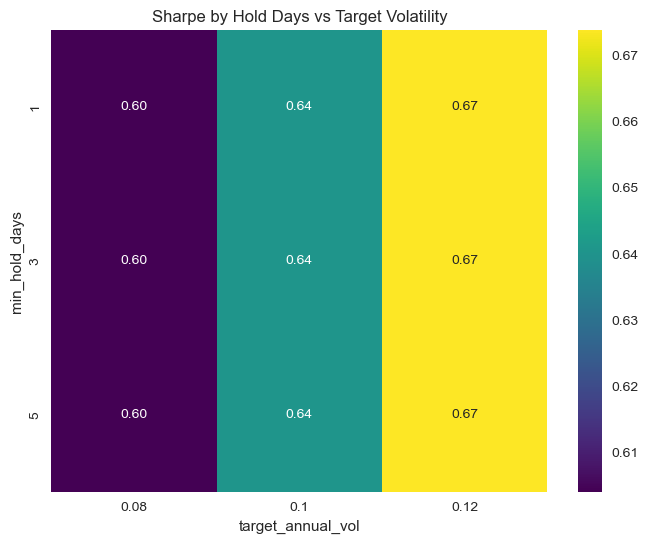

In [13]:
import seaborn as sns

plt.figure(figsize=(8,6))
pivot = df_stageC.pivot_table(values="sharpe", index="min_hold_days", columns="target_annual_vol")
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title("Sharpe by Hold Days vs Target Volatility")
plt.show()

### Stage D: Distribution of Model Predictions

count    1350.000000
mean        0.552331
std         0.046264
min         0.446382
25%         0.520228
50%         0.544703
75%         0.578933
max         0.718128
dtype: float64


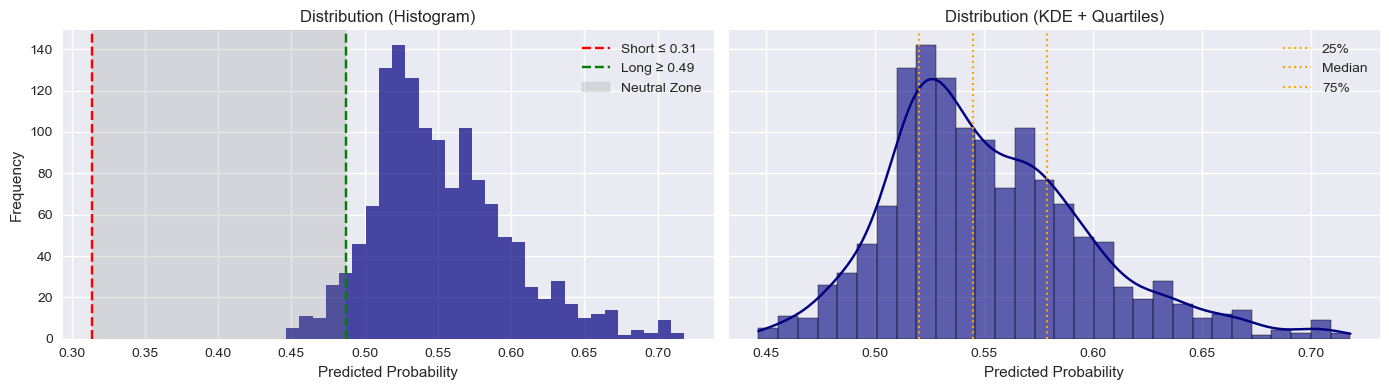

In [14]:
# ============================================
# Stage D – Distribution of Model Predictions
# ============================================
print(pd.Series(preds_cv).describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# --- (1) Histogram with thresholds (param-driven) ---
axes[0].hist(predictions, bins=30, color="navy", alpha=0.7)
axes[0].axvline(SHORT_THRESHOLD, color="red", linestyle="--", label=f"Short ≤ {SHORT_THRESHOLD:.2f}")
axes[0].axvline(LONG_THRESHOLD, color="green", linestyle="--", label=f"Long ≥ {LONG_THRESHOLD:.2f}")
axes[0].axvspan(SHORT_THRESHOLD, LONG_THRESHOLD, color="gray", alpha=0.2, label="Neutral Zone")
axes[0].set_title("Distribution (Histogram)")
axes[0].set_xlabel("Predicted Probability")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# --- (2) KDE plot with quartile markers ---
sns.histplot(predictions, bins=30, kde=True, color="navy", alpha=0.6, ax=axes[1])
q25, q50, q75 = np.percentile(predictions, [25, 50, 75])
for q, label in zip([q25, q50, q75], ["25%", "Median", "75%"]):
    axes[1].axvline(q, color="orange", linestyle=":", linewidth=1.5, label=label)
axes[1].set_title("Distribution (KDE + Quartiles)")
axes[1].set_xlabel("Predicted Probability")
axes[1].legend()

plt.tight_layout()
plt.show()

### Stage E — CV Threshold Tuning & Diagnostics
- Narrow Threshold Sweep (0.49–0.51)
- Threshold Diagnostics (Trades + Hit Rate, CV)

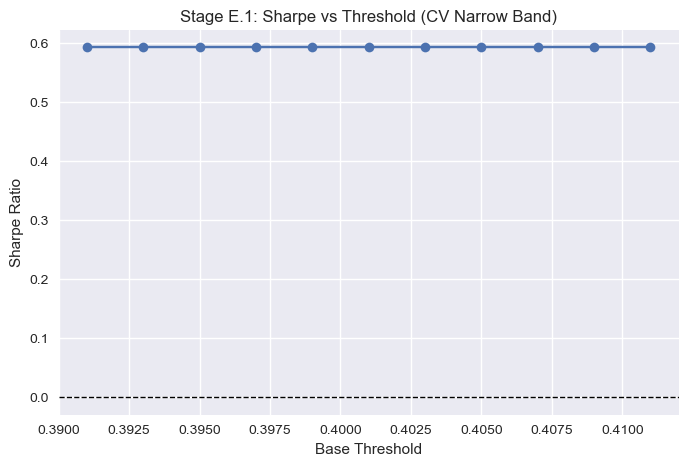

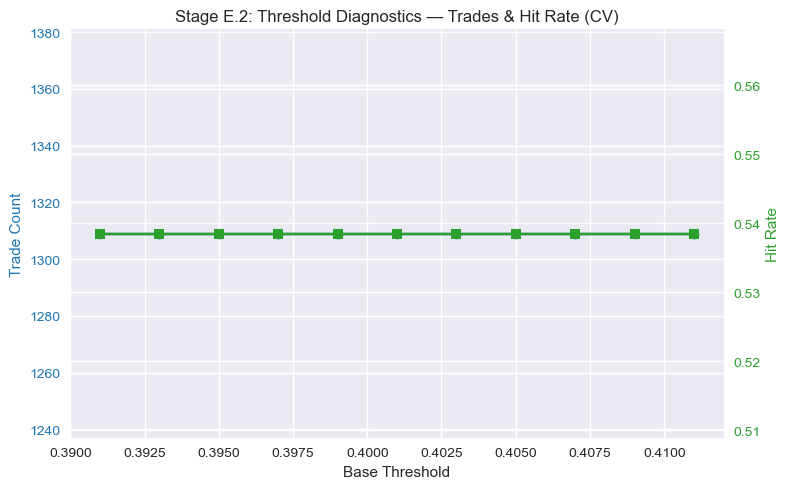

In [15]:
# ====================================================
# Stage E.1: Narrow Threshold Sweep (around PRED_THRESHOLD, CV preds only)
# ====================================================

# --- Force Stage E to use CV only (no OOS leakage) ---
preds_stageE = pd.Series(preds_cv, index=idx_cv, name="p")
pred_idx_stageE = idx_cv

# --- Prepare df_test from CV predictions ---
df_test = df.loc[pred_idx_stageE].copy()
df_test["p"] = preds_stageE
preds = preds_stageE.values  # numpy array for backtest

# --- Define sweep range (±0.01 around PRED_THRESHOLD) ---
base_thresholds = np.round(
    np.arange(PRED_THRESHOLD - 0.01, PRED_THRESHOLD + 0.0101, 0.002),
    3
)
results = []

for th in base_thresholds:
    long_th = min(th + 0.005, 0.99)
    short_th = max(th - 0.005, 0.01)
    cfg = BTConfig(long_threshold=long_th, short_threshold=short_th, neutral_band=True)

    _, stats = run_backtest_clean(df_test, preds, pred_idx_stageE, cfg=cfg)
    stats["base_threshold"] = th
    results.append(stats)

# --- Collect results ---
df_thresh = pd.DataFrame(results)
df_thresh.to_csv(OUTPUT_DIR/"tuning"/"stageE1_threshold_sweep.csv", index=False)

# --- Plot Sharpe vs threshold ---
plt.figure(figsize=(8,5))
plt.plot(df_thresh["base_threshold"], df_thresh["sharpe"], marker="o")
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Stage E.1: Sharpe vs Threshold (CV Narrow Band)")
plt.xlabel("Base Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

# =========================================================
# Stage E.2: Threshold Diagnostics (Trades + Hit Rate, CV)
# =========================================================
trade_counts = []
hit_rates = []

for th in base_thresholds:
    cfg = BTConfig(
        long_threshold=min(th + 0.005, 0.99),
        short_threshold=max(th - 0.005, 0.01),
        neutral_band=True
    )
    _, stats = run_backtest_clean(df_test, preds, pred_idx_stageE, cfg=cfg)
    trade_counts.append(stats.get('turnover', 0))
    hit_rates.append(stats.get('hit_rate', np.nan))

# --- Collect diagnostics ---
diagnostics_df = pd.DataFrame({
    "threshold": base_thresholds,
    "trade_count": trade_counts,
    "hit_rate": hit_rates
})
diagnostics_df.to_csv(OUTPUT_DIR/"tuning"/"stageE2_threshold_diagnostics.csv", index=False)

# --- Plot diagnostics ---
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.set_title("Stage E.2: Threshold Diagnostics — Trades & Hit Rate (CV)")
ax1.plot(diagnostics_df["threshold"], diagnostics_df["trade_count"], 
         marker="o", color="tab:blue", label="Trade Count")
ax1.set_xlabel("Base Threshold")
ax1.set_ylabel("Trade Count", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(diagnostics_df["threshold"], diagnostics_df["hit_rate"], 
         marker="s", color="tab:green", label="Hit Rate")
ax2.set_ylabel("Hit Rate", color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

fig.tight_layout()
plt.show()

# AI Strategy Performance Review
## OOS Confirmatory Run (2022+)

=== Stage H: OOS confirmatory (train+val < 2022, predict 2022+) ===


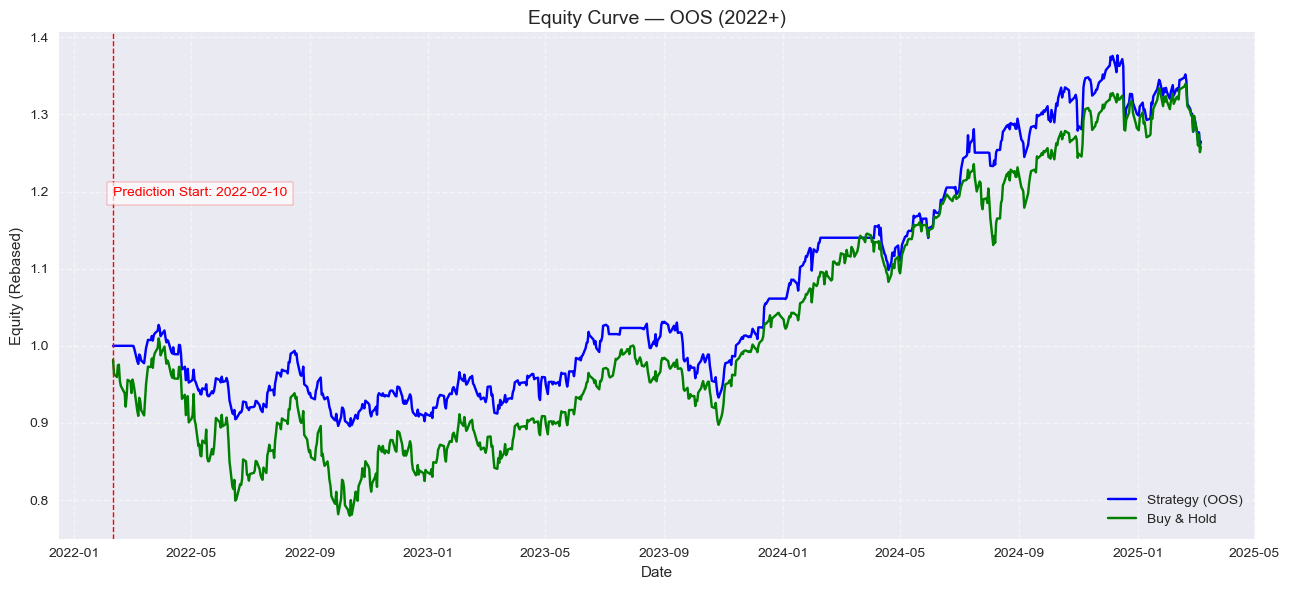

=== OOS Backtest Summary ===
| Metric       | Value      |
|--------------|------------|
| Window Start | 2022-02-10 |
| Window End   | 2025-03-07 |
| Bars         | 770        |
| Metric       |   Strategy | Benchmark   |
|--------------|------------|-------------|
| Total Return |      0.265 | 0.258       |
| CAGR         |      0.08  | 0.078       |
| Ann Vol      |      0.123 | 0.173       |
| Sharpe       |      0.624 | 0.434       |
| Max Drawdown |     -0.128 | -0.228      |
| Hit Rate     |      0.452 |             |
| Turnover     |    667     |             |


In [17]:
# ======================================================
# OOS confirmatory (train+val < 2022, predict 2022+)
# ======================================================

print("=== Stage H: OOS confirmatory (train+val < 2022, predict 2022+) ===")

# --- Define split points ---
VAL_SPLIT = "2020-01-01"   # start of validation
H_SPLIT   = "2022-01-01"   # OOS cutoff
EVAL_END   = "2025-03-07" 
oos_idx    = df.loc[H_SPLIT:EVAL_END].index 

# --- Index sets ---
trainval_idx = df.index[df.index < H_SPLIT]   # all data < 2022
test_idx     = df.index[df.index >= H_SPLIT] # OOS data ≥ 2022

# --- Features (train+val, test) [no regime features] ---
Xtrval2 = df.loc[trainval_idx, FEATURE_COLS].values
Xte2    = df.loc[test_idx,     FEATURE_COLS].values

ytrval  = df.loc[trainval_idx, "label"]
yte     = df.loc[test_idx,     "label"]

# --- Scaling (fit on train+val only) ---
sc = StandardScaler().fit(Xtrval2)
Xtrval = sc.transform(Xtrval2)
Xte    = sc.transform(Xte2)

# --- Sequences ---
Xtrval_seq, ytrval_seq = create_sequences(Xtrval, ytrval, SEQ_LEN)
Xte_seq,    yte_seq    = create_sequences(Xte,    yte,    SEQ_LEN)
pred_index_oos = pd.DatetimeIndex(test_idx[SEQ_LEN-1:])  # fixed alignment

# --- Model ---
model = get_transformer_model(
    (SEQ_LEN, Xtrval_seq.shape[2]),
    embed_dim=64, num_heads=4, ff_dim=128,
    dropout=0.3, lr=0.0001
)

# Train once on full train+val (<2022), no validation callbacks now
hist = model.fit(
    Xtrval_seq, ytrval_seq,
    epochs=20, batch_size=64, verbose=0
)

# --- Predict OOS ---
pred_oos = model.predict(Xte_seq, verbose=0).flatten()
pred_series_oos = pd.Series(pred_oos, index=pred_index_oos, name="p")

# --- Backtest ---
cfg = BTConfig(long_threshold=LONG_THRESHOLD, short_threshold=SHORT_THRESHOLD)
df_bt_oos, summary_oos = run_backtest_clean(
    df=df, predictions=pred_series_oos, pred_index=pred_index_oos, cfg=cfg
)

# --- Save artifacts ---
oos_dir = OUTPUT_DIR/"oos_final"
oos_dir.mkdir(parents=True, exist_ok=True)
np.save(oos_dir/"pred_oos.npy", pred_oos)
np.save(oos_dir/"pred_index_oos.npy", pred_index_oos.values.astype("datetime64[ns]"))
pd.DataFrame([summary_oos]).to_csv(oos_dir/"backtest_oos_summary.csv", index=False)

# --- Plot equity curve ---
plt.figure(figsize=(13, 6))
plt.plot(df_bt_oos.loc[pred_index_oos].index,
         df_bt_oos.loc[pred_index_oos, "strategy_equity"],
         label="Strategy (OOS)", color="blue")
plt.plot(df_bt_oos.loc[pred_index_oos].index,
         df_bt_oos.loc[pred_index_oos, "bh_equity"],
         label="Buy & Hold", color="green")

pred_start = pred_index_oos[0]
plt.axvline(pred_start, color="red", linestyle="--", linewidth=1)
plt.text(pred_start,
         df_bt_oos["bh_equity"].max() * 0.9,
         f"Prediction Start: {pred_start.date()}",
         rotation=0, color="red", ha="left", va="top", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7, edgecolor="red"))

plt.title("Equity Curve — OOS (2022+)", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Equity (Rebased)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(oos_dir/"equity_curve_oos_enhanced.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Pretty print summary (metadata + comparison) ---
from tabulate import tabulate

# Metadata
meta_df = pd.DataFrame({
    "Metric": ["Window Start", "Window End", "Bars"],
    "Value": [
        summary_oos["window_start"],
        summary_oos["window_end"],
        summary_oos["bars"],
    ]
})

# Strategy vs Benchmark metrics
metrics_map = {
    "Total Return": ("total_return", "bh_total_return"),
    "CAGR": ("cagr", "bh_cagr"),
    "Ann Vol": ("ann_vol", "bh_ann_vol"),
    "Sharpe": ("sharpe", "bh_sharpe"),
    "Max Drawdown": ("max_drawdown", "bh_max_drawdown"),
    "Hit Rate": ("hit_rate", None),
    "Turnover": ("turnover", None),
}

rows = []
for label, (s_key, b_key) in metrics_map.items():
    rows.append([
        label,
        f"{summary_oos.get(s_key, np.nan):.3f}",
        f"{summary_oos.get(b_key, np.nan):.3f}" if b_key else ""
    ])

summary_df = pd.DataFrame(rows, columns=["Metric", "Strategy", "Benchmark"])

print("=== OOS Backtest Summary ===")
print(tabulate(meta_df, headers="keys", tablefmt="github", showindex=False))
print(tabulate(summary_df, headers="keys", tablefmt="github", showindex=False))

### Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

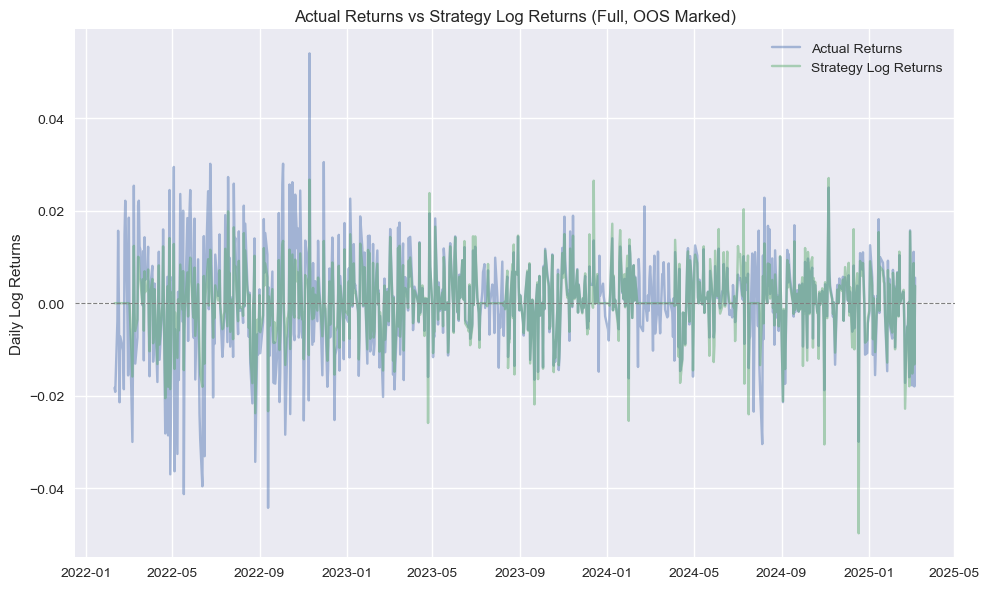

In [18]:
# ======================================================
# Plot: Actual vs Strategy Returns (Full history, OOS marked)
# ======================================================

plt.figure(figsize=(10, 6))
plt.plot(df_bt_oos.index, df_bt_oos['log_returns'], 
         label="Actual Returns", alpha=0.45)
plt.plot(df_bt_oos.index, df_bt_oos['strat_log_ret'], 
         label="Strategy Log Returns", alpha=0.45)

# OOS cutoff marker
#plt.axvline(pd.to_datetime("2022-01-01"), color="red", linestyle="--", linewidth=1)
#plt.text(pd.to_datetime("2022-01-01"),
         #df_bt_oos['log_returns'].max() * 0.8,
         #"OOS Start",
         #rotation=0, color="red", ha="left", va="top", fontsize=10,
         #bbox=dict(facecolor="white", alpha=0.7, edgecolor="red"))

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Strategy Log Returns (Full, OOS Marked)")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'returns_comparison_full_oos.png', dpi=300, bbox_inches='tight')
plt.show()

## `quantstats` Analytics Module

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2022-03-03   2022-03-03
End Period          2025-03-07   2025-03-07
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       89.0%

Cumulative Return   31.54%       26.47%
CAGR﹪              6.48%        5.53%

Sharpe              0.62         0.69
Prob. Sharpe Ratio  85.72%       88.23%
Sortino             0.88         0.97
Sortino/√2          0.62         0.69
Omega               1.13         1.13

Max Drawdown        -22.77%      -12.79%
Longest DD Days     622          458

Gain/Pain Ratio     0.11         0.13
Gain/Pain (1M)      0.53         0.58

Payoff Ratio        1.01         1.04
Profit Factor       1.11         1.13
Common Sense Ratio  1.18         1.09
CPC Index           0.59         0.61
Tail Ratio          1.06         0.96
Outlier Win Ratio   2.67         4.16
Outlier Loss Ratio  3.36         4.39

MTD                 -3.1%        -2.53%
3M           

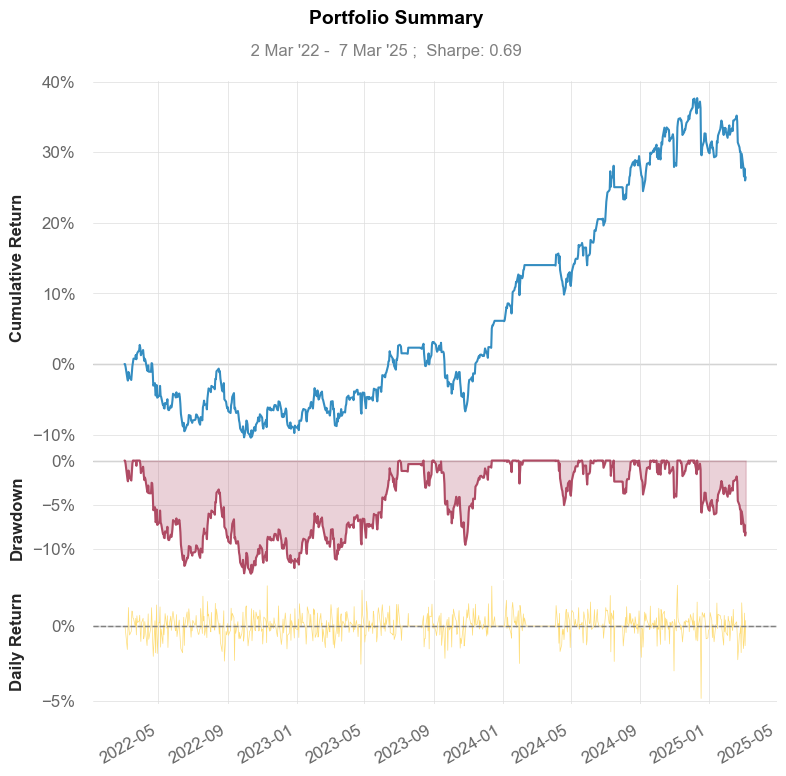

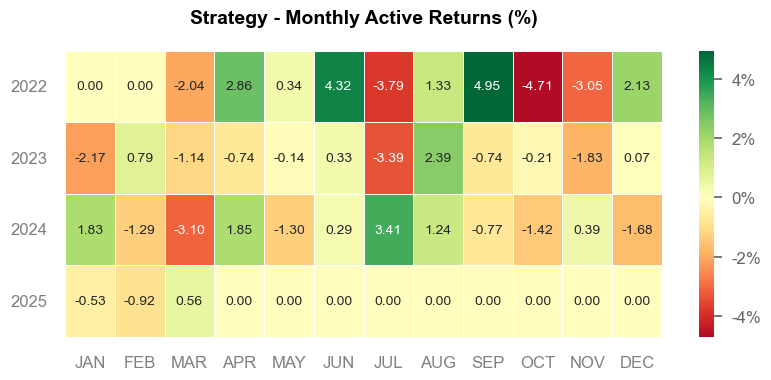

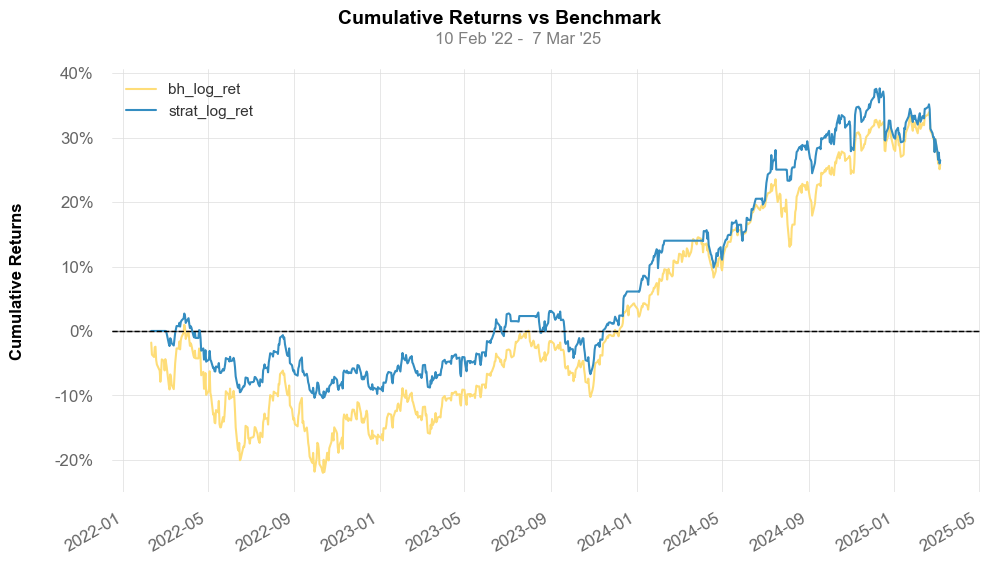

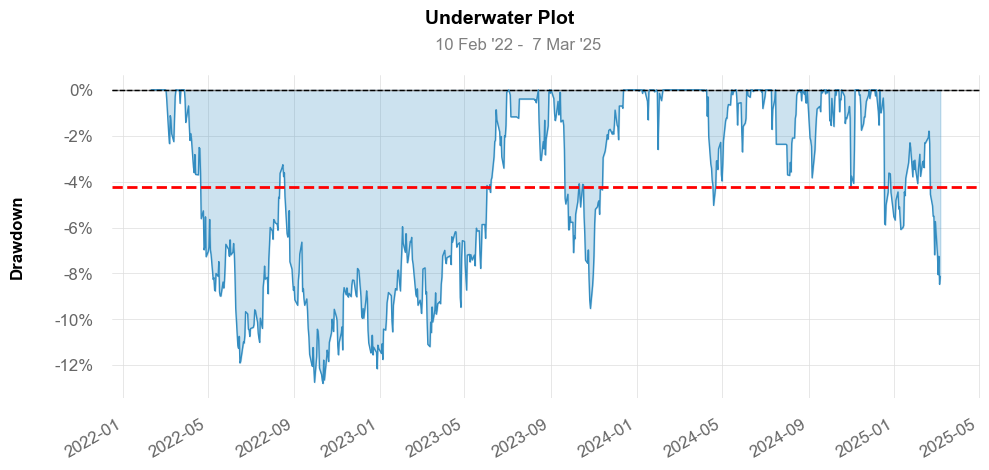

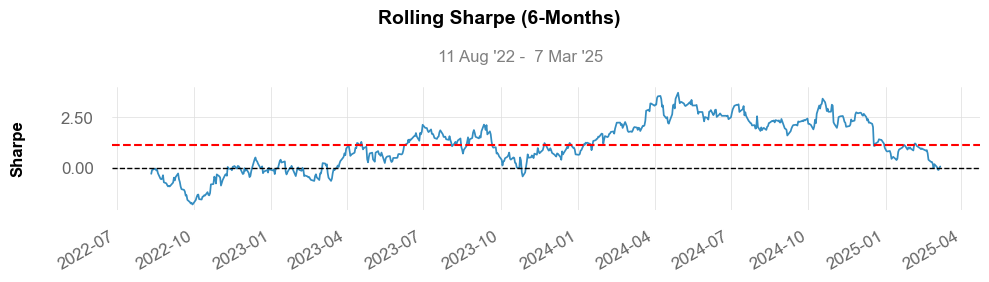

In [19]:
# ====================================================
# Stage H: QuantStats Analysis (OOS Backtest 2022+)
# ===================================================
import quantstats as qs

# Convert log returns to simple daily returns
strategy_simple_returns = np.exp(df_bt_oos['strat_log_ret']) - 1
benchmark_simple_returns = np.exp(df_bt_oos['bh_log_ret']) - 1

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)

## OOS Stress Test: Why 2022+?

We deliberately select **2022 onwards** as the out-of-sample (OOS) evaluation window.  
This period represents one of the most challenging market regimes in recent history:

- **Rate Shock:** The Fed executed its fastest tightening cycle since the Volcker era, driving rates from near-zero to 4.5%+ within a year.  
- **Correlation Breakdown:** Both equities and Treasuries sold off together, breaking the classic 60/40 diversification.  
- **Volatility Spikes:** Equity (VIX), bond (MOVE), and FX volatilities surged simultaneously.  
- **Liquidity Stress:** Quantitative tightening (QT) drained market liquidity and widened credit spreads.  
- **Macro Narrative Shifts:** Inflation shock → policy shock → earnings compression.

By validating the Attention-LSTM on this window, we **stress test robustness under adverse macro conditions** rather than just capturing momentum in easy bull markets.  
Even modest Sharpe ratios in this regime are meaningful, since most strategies struggled to adapt.
